<a href="https://colab.research.google.com/github/benru89/histology_dcgan/blob/master/histo_dcgan_colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup:

1) Make sure GPU is enabled, go to edit->notebook settings->Hardware Accelerator GPU

2) make a copy to your google drive, click on copy to drive in panel

Note: colab will reset after 12 hours make sure to save your model checkpoints to google drive around 6 hours mark (one tick), the second tick will show up before the reset but I have lost work by not being able to save it to drive in time, then go to runtime->reset all runtimes. Now copy your train model back into colab and start training again from the previous checkpoint.

It will take about 6 hours per tick on a k80 which colab currently uses to train one tick with transfer learning for stylegan, I usually save my checkpoint at that point and reset all runtimes to start training again.

In [1]:
!nvidia-smi

Wed Oct 14 22:49:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone the repo from github

In [2]:
!rm -rf sample_data/
!rm -rf histology_dcgan/
!git clone --single-branch --branch "master"  https://github.com/benru89/histology_dcgan

Cloning into 'histology_dcgan'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 363 (delta 0), reused 0 (delta 0), pack-reused 360
Receiving objects: 100% (363/363), 182.32 MiB | 35.25 MiB/s, done.
Resolving deltas: 100% (185/185), done.


mount directory of latest checkpoints


In [3]:
!rm -rf /content/checkpoints/
!mkdir /content/checkpoints/
!gdown -O /content/checkpoints/checkpoint "https://drive.google.com/uc?export=download&id=1Cx-TX4CUvcXbPx64T0MXco8HTWSfv6z0"
!gdown -O "/content/checkpoints/model-66000.index" "https://drive.google.com/uc?export=download&id=1Maf1Y8NLA6l3xzX__gJHeg1ZKpJyOInb"
!gdown -O "/content/checkpoints/model-66000.meta" "https://drive.google.com/uc?export=download&id=1DGAp-hErdMNsZrQoRXd0yWhwFn7zFopk"
!gdown "https://drive.google.com/uc?export=download&id=1um7LaaDpin-CtvbefKuGCO6u_UXuaQkW" -O "/content/checkpoints/model-66000.data-00000-of-00001"
!ls -al /content/checkpoints/

Downloading...
From: https://drive.google.com/uc?export=download&id=1Cx-TX4CUvcXbPx64T0MXco8HTWSfv6z0
To: /content/checkpoints/checkpoint
100% 121/121 [00:00<00:00, 222kB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Maf1Y8NLA6l3xzX__gJHeg1ZKpJyOInb
To: /content/checkpoints/model-66000.index
100% 4.29k/4.29k [00:00<00:00, 6.73MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1DGAp-hErdMNsZrQoRXd0yWhwFn7zFopk
To: /content/checkpoints/model-66000.meta
5.21MB [00:00, 82.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1um7LaaDpin-CtvbefKuGCO6u_UXuaQkW
To: /content/checkpoints/model-66000.data-00000-of-00001
1.23GB [00:05, 220MB/s]
total 1207568
drwxr-xr-x 2 root root       4096 Oct 14 22:50 .
drwxr-xr-x 1 root root       4096 Oct 14 22:49 ..
-rw-r--r-- 1 root root        121 Oct 14 22:49 checkpoint
-rw-r--r-- 1 root root 1231302724 Oct 14 22:50 model-66000.data-00000-of-00001
-rw-r--r-- 1 root root       4289 Oct 

In [4]:
with open("/content/histology_dcgan/config.json", "r+") as file:
    file.seek(0)
    file.write("""{
     "active_config": "camelyon_17_16_level1", 
     "camelyon_17_16_level1": 
     {
       "output": {"dimX": 256, "dimY": 256, "dimZ": 3},
       "input": {"z_noise_dim": 256, "batch_size": 32}, 
       "training": {"f_dim": 128, "num_epochs": 100, "d_learning_rate": 0.0002,"g_learning_rate": 0.0002, "beta1": 0.5}, 
       "base_path": "/content/", 
       "data_path": "datasets/camelyon_17_16_level1_n/", 
       "chkpts_path": "checkpoints/", 
       "graphs_path": "graphs",
       "output_path": "output/", 
       "save_model_every": 500, 
       "save_example_every": 10, 
       "print_info_every": 20
       }
    }""")
    file.truncate()

In [5]:
%cd histology_dcgan
import sys
sys.path.append('/content/histology_dcgan')
%tensorflow_version 1.x

/content/histology_dcgan
TensorFlow 1.x selected.


In [6]:
import os
import latent_space
import output
from histology_main import get_session,close_session
import constants
from utils import change_active_config, natural_keys
from evaluation import load_graph, read_tensor_from_image_file, load_labels
import dcgan_alt as dcgan
import cv2

#otros
import os
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import random
from importlib import reload
import imageio
from glob import glob
%matplotlib inline


In [7]:
session, input_real, input_z, input_g_y = get_session(1)
z_batch_tensor = tf.random.uniform(
        (constants.BATCH_SIZE, constants.Z_NOISE_DIM), dtype=tf.float32, minval=-1, maxval=1)

prefix = "histo_"




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:Restoring parameters from /content/checkpoints/model-66000
66000


In [8]:
!mkdir /content/output

In [9]:
#delete all generated samples and generate new ones.
[os.remove(file) for file in glob(constants.FULL_OUTPUT_PATH + "*" + prefix + "*.*")]
labels = np.random.randint(0,2, constants.BATCH_SIZE)
labels = np.eye(2)[labels]
output.generate_samples(session, z_batch_tensor, input_z, input_g_y , labels, constants.BATCH_SIZE * 10, save_tensor=True, name_prefix=prefix)

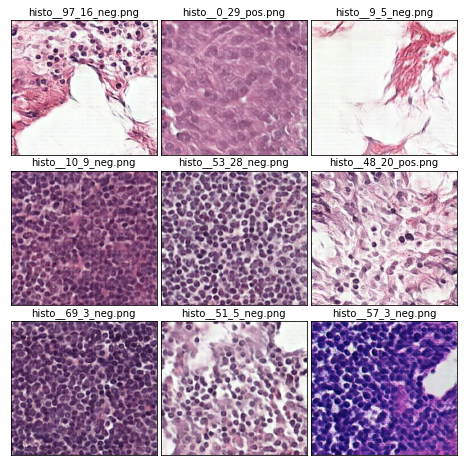

In [10]:
all_files = glob(constants.FULL_OUTPUT_PATH + "*" + prefix + "*.png")
files_to_show = random.sample(all_files,9)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.12, wspace=0.03)
for i,img_file in enumerate(files_to_show):
    img = plt.imread(img_file)
    alpha=1.4
    beta=0.1
    #img=cv2.addWeighted(img,alpha,np.zeros(img.shape, img.dtype),0,beta)
    plt.subplot(3, 3, i+1).set_title(img_file.split("/")[-1]).set_fontsize(10)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    i=i+1

In [21]:
def show(labels, tensors):
    plt.figure(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.2, wspace=0.03)
    for i,img in enumerate(tensors):
        img = np.expand_dims(img,0)
        z_ = tf.placeholder(tf.float32, [1, constants.Z_NOISE_DIM])
        samples = session.run(dcgan.sampler(z_,input_g_y,1), feed_dict={z_: img,input_g_y:labels})
        img = np.squeeze(samples)
        subplt = plt.subplot(1, 6, i+1)
        plt.imshow(img / 2 + 0.5)
        plt.xticks([])
        plt.yticks([])



ValueError: ignored

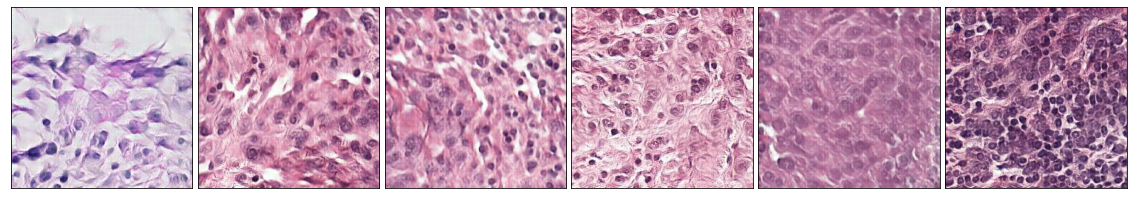

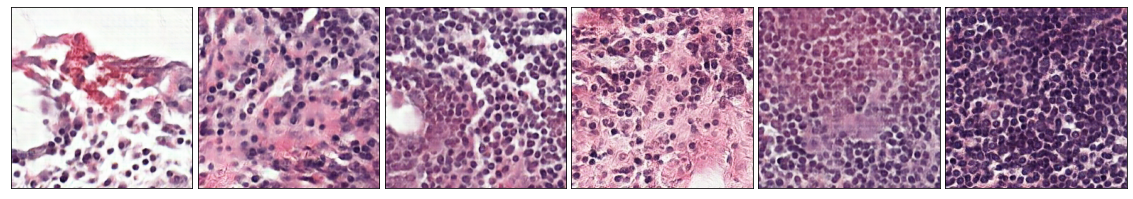

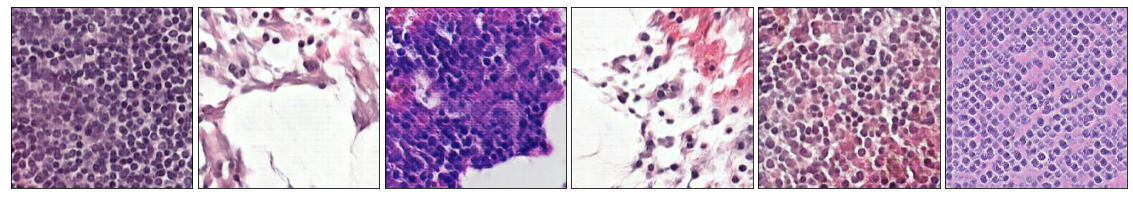

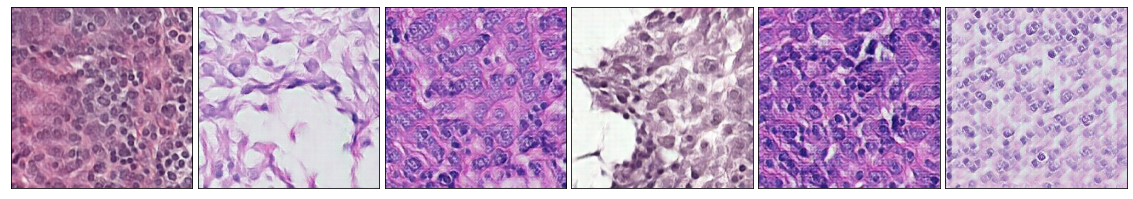

<Figure size 1440x1440 with 0 Axes>

In [29]:

neg_vectors = [file for file in glob(constants.FULL_OUTPUT_PATH + "*neg*.txt")]
pos_vectors = [file for file in glob(constants.FULL_OUTPUT_PATH + "*pos*.txt")]
        
random.shuffle(neg_vectors)
random.shuffle(pos_vectors)
cancer_tensors = [np.loadtxt(pos_vectors[n]) for n in range(6)]        
normal_lumen_tensors = [np.loadtxt(neg_vectors[n]) for n in range(6)]        


labels = [1] 
labels = np.eye(2)[labels]
show(labels, cancer_tensors)
labels = [0] 
labels = np.eye(2)[labels]
show(labels, cancer_tensors)

labels = [0] 
labels = np.eye(2)[labels]
show(labels, normal_lumen_tensors)
labels = [1] 
labels = np.eye(2)[labels]
show(labels, normal_lumen_tensors)



In [34]:
normal_lumen_tensors

[array([ 0.88038492,  0.03969526, -0.81494451, -0.42824268,  0.40457392,
        -0.99379992, -0.51922011, -0.03130817,  0.32715869, -0.61098552,
         0.32762265, -0.54590154,  0.53350616,  0.87780643, -0.38386154,
        -0.13710213, -0.44088173,  0.89809895,  0.86682892, -0.95946932,
        -0.39221859,  0.02962446, -0.03586268, -0.78589845, -0.6875813 ,
        -0.76513171, -0.93653822, -0.78815627, -0.84456396,  0.33308649,
        -0.93975997, -0.6752305 ,  0.34468293, -0.84454775,  0.68270779,
        -0.44090796,  0.72771811,  0.1185298 ,  0.2422657 , -0.25439644,
         0.99916482, -0.48990011,  0.7443192 ,  0.35774565, -0.69495273,
         0.06585312,  0.92795801, -0.45546794,  0.62184119,  0.82321572,
        -0.9859581 , -0.43271971, -0.91027665,  0.08767867, -0.86270189,
         0.07097793,  0.78143024, -0.68247509, -0.26223898, -0.72496295,
        -0.51482558,  0.19777751,  0.58610606, -0.61369133, -0.51168776,
        -0.0548842 ,  0.10534239, -0.25127745,  0.3

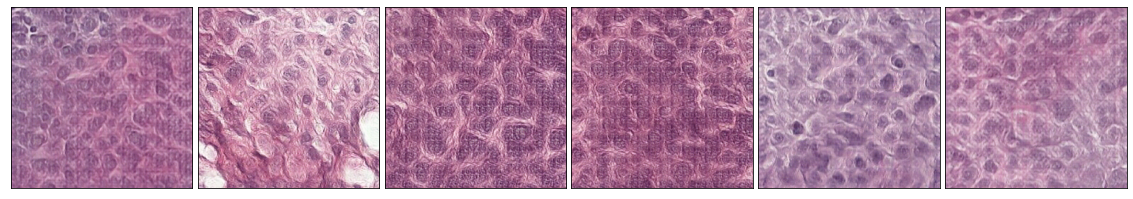

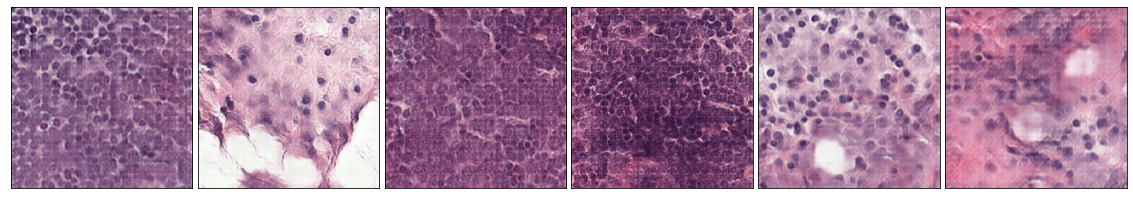

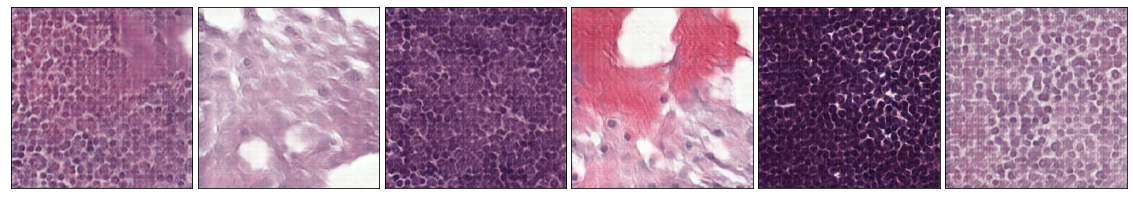

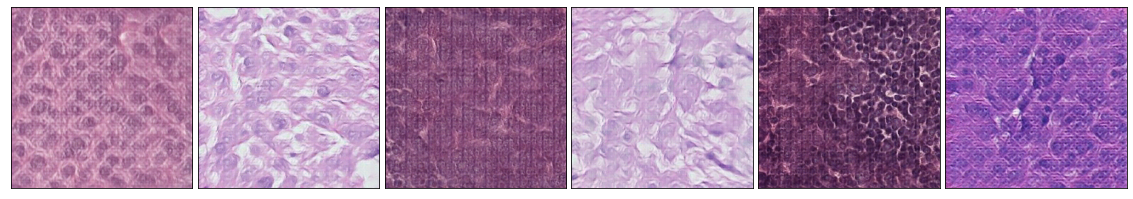

In [56]:

cancer_avg_tensors = [latent_space.average_tensor([np.loadtxt(pos_vectors[n]) for n in random.sample(range(100), 2)]) for i in range(6)]
normal_avg_tensors = [latent_space.average_tensor([np.loadtxt(neg_vectors[n]) for n in random.sample(range(100), 2)]) for i in range(6)]
labels = [1] 
labels = np.eye(2)[labels]
show(labels, cancer_avg_tensors)
labels = [0] 
labels = np.eye(2)[labels]
show(labels, cancer_avg_tensors)

labels = [0] 
labels = np.eye(2)[labels]
show(labels, normal_avg_tensors)
labels = [1] 
labels = np.eye(2)[labels]
show(labels, normal_avg_tensors)

In [59]:
[os.remove(file) for file in glob(constants.FULL_OUTPUT_PATH+"*interp*.png")]
punto_a = np.loadtxt(pos_vectors[random.randint(0,200)])
punto_b = np.loadtxt(pos_vectors[random.randint(200,400)])
latent_space.interpolate(session, punto_a, punto_b, [0,0], 72, prefix = "a")
latent_space.interpolate(session, punto_b, punto_a, [1,1], 72, prefix = "b")

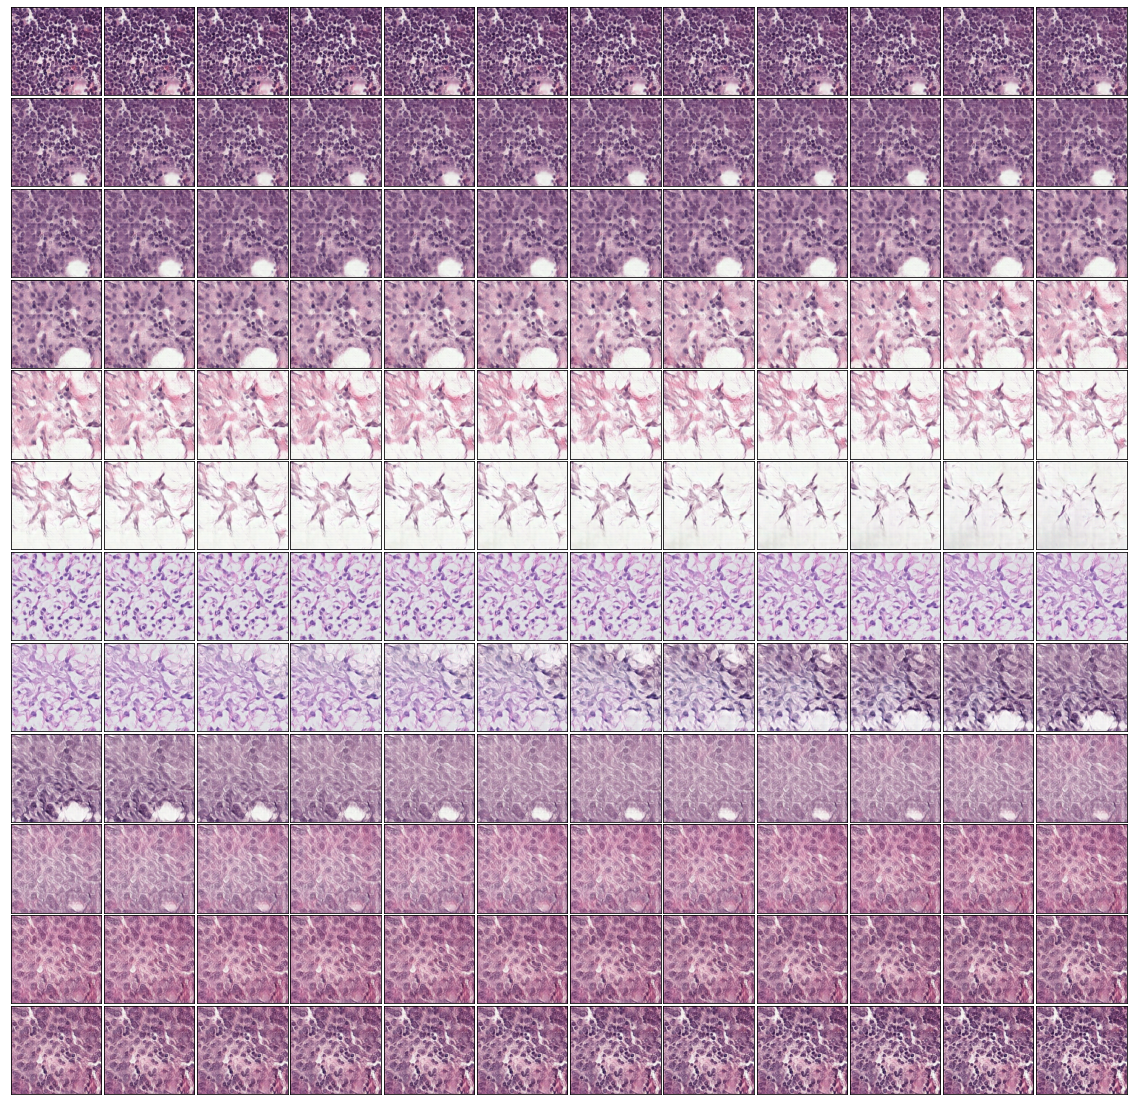

In [61]:
all_files = glob(constants.FULL_OUTPUT_PATH+"*interp*")
all_files.sort(key=natural_keys)
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i,img in enumerate(all_files):
    img = plt.imread(img)
    plt.subplot(12, 12, i+1)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])

In [67]:
!cd /content/stylegan/frames692710
!ffmpeg -i /content/stylegan/frames692710/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./faves13.mp4
  


/bin/bash: line 0: cd: /content/stylegan/frames692710: No such file or directory
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack